In [65]:
# Imports for core lib
import numpy as np
from typing import Dict, Hashable, Tuple
import itertools

import torch as th
from torchvision import transforms
from pytorch3d.ops.perspective_n_points import efficient_pnp
from pytorch3d.transforms import so3_relative_angle


In [2]:
# Imports for visualization
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Imports for Data
from top.data.objectron_detection import ObjectronDetection
from top.data.colored_cube_dataset import ColoredCubeDataset
from top.data.schema import Schema

In [20]:
# Extra imports for visualization?
from top.data.transforms.visualize import DrawBoundingBoxFromKeypoints

In [4]:
def get_cube_points() -> th.Tensor:
    """ Get cube points, sorted in descending order by axes and coordinates. """
    points_3d = list(itertools.product(
        *zip([-0.5, -0.5, -0.5], [0.5, 0.5, 0.5])))
    points_3d = np.insert(points_3d, 0, [0, 0, 0], axis=0)
    points_3d = th.as_tensor(points_3d, dtype=th.float32).reshape(-1, 3)
    return points_3d

In [22]:
device = th.device('cpu:0')
vis_key = '__img_with_box__'
dataset = ObjectronDetection(ObjectronDetection.Settings(), False)
draw_keypoints = DrawBoundingBoxFromKeypoints(DrawBoundingBoxFromKeypoints.Settings(key_out = vis_key)
                                             )
cube_points = get_cube_points()

In [40]:
idata = iter(dataset)

In [128]:
data_0 = next(idata)
data = draw_keypoints(data_0)

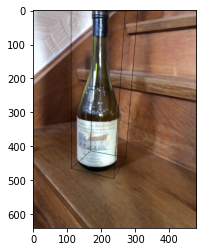

In [129]:
# Show Image ...
image = data[vis_key].permute(1,2,0).detach().cpu().numpy()
plt.imshow(image)
plt.show()

In [130]:
def compute_transforms(data):
    # Extract relevant fields from the dataset.
    points_2d = data[Schema.KEYPOINT_2D][..., :2].clone()
    points_3d = cube_points[None, ...] * data[Schema.SCALE][:, None, :]
    P = data[Schema.PROJECTION].reshape(4,4)
    
    # Preprocess `points_2d` to comform to `efficient_pnp` convention.
    # points_2d is in X-Y order (i.e. minor-major), normalized to range (0.0, 1.0).
    points_2d -= 0.5
    points_2d *= 2.0 / P[None, None, (0,1), (0,1)]
    
    # Compute PNP solution ...
    try:
        solution = efficient_pnp(points_3d, points_2d)
    except RuntimeError as e:
        print('Encountered error during PnP : {}'.format(e))
        return None
    
    R, T = solution.R, solution.T
    
    # NOTE(ycho): In the PNP solution convention,
    # y[i] = Proj(x[i] R[i] + T[i])
    # In the objectron convention,
    # y[i] = Proj(R[i] x[i] + T[i])
    R = th.transpose(R, -2, -1)

    # NOTE(ycho): additional correction to account for coordinate flipping.
    DR = th.as_tensor([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, -1]
    ], dtype=th.float32, device=R.device)
    R = th.einsum('ab,...bc->...ac', DR, R)
    T = th.einsum('ab,...b->...a', DR, T)
    
    return (R, T)

In [131]:
def compute_deltas(R_src, T_src, R_dst, T_dst):
    err_R = so3_relative_angle(R_src, R_dst)
    # NOTE(ycho): Account for occasional (...,3,1) inputs.
    Tdim = (-2,-1) if (T_src.shape[-1]==1) else -1
    
    print(T_src.shape)
    print(T_dst.shape)
    err_T = th.norm(T_src - T_dst, dim = Tdim)
    return (err_R, err_T)

In [132]:
R_gt = data[Schema.ORIENTATION].reshape(-1,3,3)
T_gt = data[Schema.TRANSLATION].reshape(1,3)
sol = compute_transforms(data)
if sol is None:
    print('Computing solution failed')
else:
    R_out, T_out = sol
    
    print('GROUND TRUTH')
    print(R_gt)
    print(T_gt)

    print('OUTPUT')
    print(R_out)
    print(T_out)
    
    dR, dT = compute_deltas(R_out, T_out, R_gt, T_gt)
    print('dR = {}'.format(dR))
    print('dT = {}'.format(dT))

ERROR
tensor([0.0613]) tensor([0.0019])
GROUND TRUTH
tensor([[[ 0.1330, -0.9642,  0.2292],
         [ 0.9527,  0.0605, -0.2979],
         [ 0.2733,  0.2580,  0.9267]]])
tensor([[-0.0476, -0.0237, -0.3600]])
OUTPUT
tensor([[[ 0.1092, -0.9427,  0.3151],
         [ 0.9940,  0.1042, -0.0328],
         [-0.0020,  0.3168,  0.9485]]])
tensor([[-0.0511, -0.0333, -0.4571]])
torch.Size([1, 3])
torch.Size([1, 3])
dR = tensor([0.2856])
dT = tensor([0.0977])
